<img src="https://gitlab.irit.fr/toc/ens-n7/texCoursN7/-/raw/main/LOGO_INP_N7.png" alt="N7" height="80"/>

<img src="https://gitlab.irit.fr/toc/ens-n7/texCoursN7/-/raw/main/logo-insa.png" alt="INSA" height="80"/>

# Méthodes de Runge-Kutta implicites - TP Projet

- Date : 2023-2024
- Durée approximative : inconnue

**Nom** : Foucher de Brandois

**Prénom** : Félix

## Rendu et consignes

Une fois le travail terminé, vous enverrez directement le fichier `.ipynb` par email à l'adresse : `olivier.cots@toulouse-inp.fr`.

- **Date limite du rendu : mercredi 15/11/2023 à 23h59.** Attention, à partir de 24h, 2 points est enlevé de la note finale toutes les 30 minutes.
- **Attention :** Le fichier doit être renommé de la façon suivante : `rk_implicites_NOM_Prenom.ipynb`. 4 points enlevés si le nom du fichier n'est pas respecté.
- **Documents autorisés :** vous pouvez utiliser votre polycopié et les TPs précédents.

## Introduction

Nous allons dans ce TP, implémenter quelques méthodes de Runge-Kutta **implicites** (voir **polycopié Section 8.2**) et étudier leur convergence. On considère un pas de temps $h$ uniforme. Une méthode à un pas implicite est convergente si pour toute solution $x(\cdot, t_0, x_0)$ d'un problème de Cauchy, la suite approximante ${(x_i)}_i$ donnée par la méthode à un pas implicite vérifie 
$$
    \max_{1 \le i \le N}\, \|{x(t_i, t_0, x_0) - x_i}\| \to 0 
    \quad\text{quand}\quad h \to 0.
$$

Si la convergence est d'ordre $p$ alors il existe une constante $C \ge 0$ telle que l'**erreur globale** $E$ vérifie

$$
    E := \max_{1 \le i \le N}\, \|{x(t_i, t_0, x_0) - x_i}\| \le C\, h^p.
$$

Faisons l'hypothèse que $E = M\, h^p$ pour un certain $M \ge 0$. En passant au logarithme, on obtient

$$
    \log(E) = \log(M) + p\, \log(h).
$$

Nous en déduisons que si on trace $\log(E)$ en fonction de $\log(h)$, on doit obtenir une droite de pente $p$. C'est ce que nous allons vérifier dans ce TP.

In [118]:
# activate local project
using Pkg
Pkg.activate(".")

# load packages
using LinearAlgebra
using Plots
using Plots.PlotMeasures
using Polynomials

#
px = PlotMeasures.px;

  Activating project at `~/Cours/S7/Calcul_diff/tp`


In [119]:
# Fonctons auxiliaires 

function method_infos(method)

    if method == :euler
        method_func = euler
        method_name = "Euler"
        methode_stages = 1

    elseif method == :euler_implicite 
        method_func = euler_implicite
        method_name = "Euler implicite"
        methode_stages = 1
    elseif method == :trapezes_implicite 
        method_func = trapezes_implicite
        method_name = "Trapèzes implicite"
        methode_stages = 2
    elseif method == :gauss2_implicite
        method_func = gauss2_implicite
        method_name = "Gauss implicite"
        methode_stages = 2
    
    else 
        error("Méthode d'intégration non reconnue")
    end

    return method_func, method_name, methode_stages

end

function convergence(method, f, x0, tspan, sol,  Nspan)

    # Récupération des informations sur la méthode
    method_func, method_name, methode_stages = method_infos(method)
    
    # Ecriture des choix de paramètres
    println("Méthode d'intégration : ", method_name)

    plts  = []           # Liste des graphiques

    for N ∈ Nspan

        # Solution approchée
        ts, xs = method_func(f, x0, tspan, N) # Appel de la méthode d'intégraton

        # Affichage de la solution approchée
        plt = plot(ts, xs, label=method_name, marker=:circle)

        # Affichage de la solution analytique
        plot!(plt, sol, label="Analytic")

        # Mise en forme du graphique
        plot!(plt, xlims=(tspan[1]-0.1, tspan[2]+0.1), ylims=(-0.2, 1.65), 
        title="h=$(round((tspan[2]-tspan[1])/N, digits=2))", titlefont = font(12,"Calibri"),
        xlabel="t", ylabel="x(t)", left_margin=15px, bottom_margin=15px, top_margin=10px, right_margin=15px)

        # Ajout du graphique à la liste des graphiques
        push!(plts, plt)

    end

    return plts

end

xlims_ = (1e-4, 1e0)
ylims_ = (1e-13, 1e1)
xlims_nfe_ = (1e1, 1e4)
ylims_nfe_ = (1e-13, 1e1)

function ordre(method, f, x0, tspan, sol, hspan, nfespan; 
    xlims=xlims_, ylims=ylims_, xlims_nfe=xlims_nfe_, ylims_nfe=ylims_nfe_)

    plts = []           # Liste des graphiques

    #
    plt1 = plot(xaxis=:log, yaxis=:log); push!(plts, plt1)
    plt2 = plot(xaxis=:log, yaxis=:log); push!(plts, plt2)

    #
    plts = ordre(plts, method, f, x0, tspan, sol, hspan, nfespan, 
        xlims=xlims, ylims=ylims, xlims_nfe=xlims_nfe, ylims_nfe=ylims_nfe)

    # Mise en forme des graphiques
    plot!(plts[1], titlefont = font(12, "Calibri"), legend=:topleft,
    xlabel="h", ylabel="Error", left_margin=15px, bottom_margin=15px, top_margin=10px, right_margin=15px)

    plot!(plts[2], titlefont = font(12, "Calibri"), legend=:topright,
    xlabel="Calls to f", ylabel="Error", left_margin=15px, bottom_margin=15px, top_margin=10px, right_margin=15px)

    return plts
    
end

function ordre(plts_in, method, f, x0, tspan, sol, hspan, nfespan; 
    xlims=xlims_, ylims=ylims_, xlims_nfe=xlims_nfe_, ylims_nfe=ylims_nfe_)

    # Copie du graphique d'entrée
    plts = deepcopy(plts_in)

    # Récupération des informations sur la méthode
    method_func, method_name, methode_stages = method_infos(method)
    
    # Ecriture des choix de paramètres
    println("Méthode d'intégration : ", method_name)

    # Les différents nombre de pas de temps
    Nspan = round.(Int, (tspan[2]-tspan[1]) ./ hspan)

    # Calcul de l'erreur
    err = []

    for N ∈ Nspan

        # Solution approchée
        ts, xs = method_func(f, x0, tspan, N)

        # On calcule l'erreur en norme infinie
        push!(err, maximum(abs.(xs .- sol.(ts))))
        
    end

    # calcul par régression linéaire de la pente de la droite et de l'ordonnée à l'origine
    reg = fit(log10.(hspan), log10.(err), 1)
    K   = 10^reg[0]
    p   = reg[1]
    println("\nconstante du grand O : K = $(round(K, digits=5))")
    println("ordre de convergence : p = $(round(p, digits=5))")

    # Affichage de l'erreur en fonction du pas de temps: on enlève la constante K
    plot!(plts[1], hspan, err, xaxis=:log, yaxis=:log, label="$method_name", marker=:circle)

    # Affichage de la droite de régression
    #plot!(plt, hspan, hspan .^ p, label="$method_name Regression", linestyle=:dash)
    
    # Mise en forme du graphique
    plot!(plts[1], xlims=xlims, ylims=ylims)

    # Calcul de l'erreur en fonction du nombre d'appels à la fonction f
    err = []

    for Nfe ∈ Nfespan

        #
        N = round(Int, Nfe / methode_stages)

        # Solution approchée
        ts, xs = method_func(f, x0, tspan, N)

        # On calcule l'erreur en norme infinie
        push!(err, maximum(abs.(xs .- sol.(ts))))
        
    end

    # Affchage de l'erreur en fonction du nombre d'appels à la fonction f
    # Nfespan = methode_stages .* Nspan
    plot!(plts[2], Nfespan, err, xaxis=:log, yaxis=:log, label="$method_name", marker=:circle)

    # Mise en forme du graphique
    plot!(plts[2], xlims=xlims_nfe, ylims=ylims_nfe)

    return plts
    
end;

hspan_   = 10 .^ range(-4, stop=0, length=20)
Nfespan_ = 10 .^ range(0, stop=4, length=20);

In [120]:
# Fonctons de calcul

function G(f, t, x, h, k, A, C)
    for i = 1:size(A, 1)
        k[i] = f(t + h*C[i], x + h*sum(A[i, j]*k[j] for j = 1:size(A, 1)))
    end
    return k    
end

function integration(f, tspan, x0, k0, A, C, B, N, maxiter = 1000, tol = 10^(-6))
    t0, tf = tspan
    h = (tf-t0)/N
    t = t0
    ts = [t0]
    x = x0
    xs = [x0]
    k = k0

    for i in 1:N
        iter = 0
        while norm(k - G(f,t,x,h,k,A,C)) > tol && iter < maxiter
            k = G(f,t,x,h,k,A,C)
            iter += 1
        end
        x = x + h * sum(B[i]*k[i] for i = 1:length(B))
        t = t + h
        push!(ts, t)
        push!(xs, x)
    end
    return ts, xs
end


integration (generic function with 3 methods)

## L'exemple d'étude

On s'intéresse (pour les exercices 1, 2 et 3) au problème de Cauchy

$$
    \dot{x}(t) = (1-2t) x(t), \quad x(0) = x_0 = 1
$$

sur l'intervalle $[0, 3]$.

In [121]:
# Définition du problème de Cauchy
f(t, x) = (1-2t)x    # Second membre f(t, x)
x0 = 1.0             # Condition initiale
tspan = (0.0, 3.0);  # Intervalle de temps

In [122]:
# Solution analytique
function sol(t)
    return exp(t-t^2)
end;

In [123]:
# Estimation de la constante de Lipschitz de f sur [0, 3]
# Voir Théorème 8.2.2 pour l'utilité de cette estimation
function dfx(t)
    return 1-2t
end 
L = maximum(abs.(dfx.(range(0, stop=3, length=1000))))

5.0

## La méthode d'Euler implicite

La méthode d'Euler implicite est donnée par :

$$
\left\{
\begin{array}{l}
x_{n+1} = x_n + h f(t_n + h, x_{n+1}) \\
x_0 = x(t_0)
\end{array}
\right.
$$

### Exercice 1

1. Implémenter la méthode d'Euler implicite avec le point fixe (penser à voir le polycopié Section 8.2).
2. Pourquoi si $h \ge 0.2$, la méthode d'Euler implicite ne marche pas ?
3. Tracer la solution approchée et la solution exacte sur le même graphique pour différentes valeurs de $h$ que vous choisirez pour illustrer la convergence de la méthode.
4. Tracer l'erreur globale de la méthode d'Euler implicite en fonction de $h$ et vérifier que l'erreur est bien en $O(h)$.

**Attention** : pour l'algorithme du point fixe, faites attention aux critères d'arrêts (il y en a 2) ! Voir votre polycopié Section 8.2. Vous fixerez la valeur de la tolérance à $10^{-6}$ et le nombre maximum d'itérations à $1000$.

In [124]:
# Implémentation de la méthode d'Euler implicite
function euler_implicite(f, x0, tspan, N)
    k = [f(tspan[1], x0)]
    A = [1]
    C = [1]
    B = [1]
    return integration(f, tspan, x0, k, A, C, B, N)
end;

Réponses de l'exercice 1:

2. Car.....

Méthode d'intégration : Euler implicite


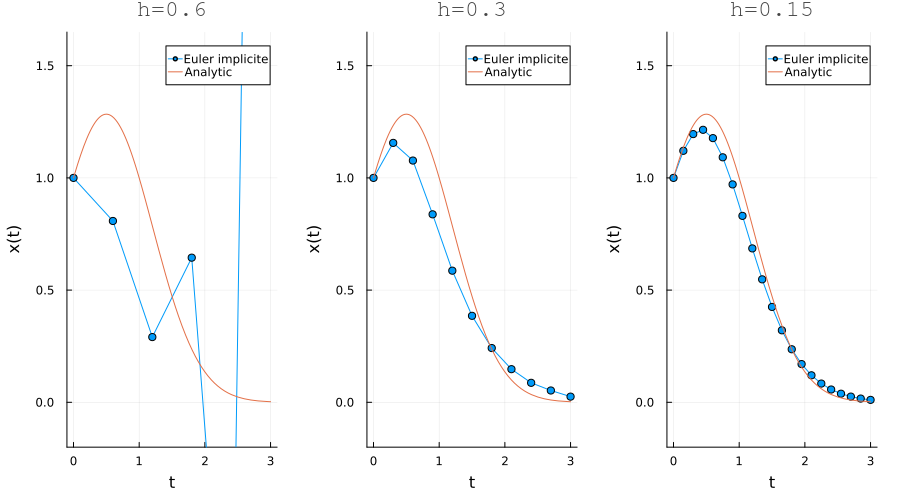

In [125]:
# Solution approchée et solution exacte
method = :euler_implicite
Nspan  = [5, 10, 20]

# Calcul des graphiques
plts = convergence(method, f, x0, tspan, sol, Nspan)

# Affichage des graphiques
plot(plts..., layout=(1, length(Nspan)), size=(900, 500))

Méthode d'intégration : Euler implicite

constante du grand O : K = 3.33566
ordre de convergence : p = 1.2152


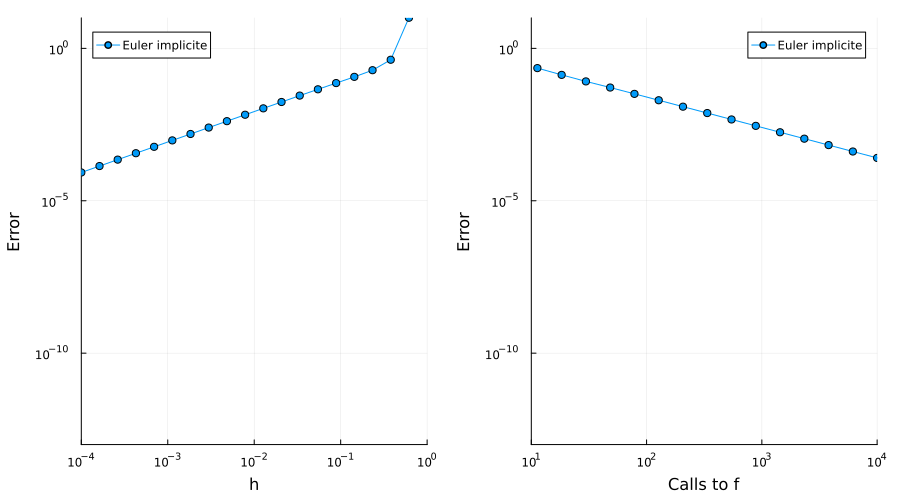

In [126]:
# Ordre de convergence de la méthode
method  = :euler_implicite
hspan   = hspan_[1e-7 .≤ hspan_ .≤ 1]
Nfespan = Nfespan_[10 .≤ Nfespan_ .≤ 1e7]

# Calcul du graphique
plt_order_euler = ordre(method, f, x0, tspan, sol, hspan, Nfespan)

# Affichage du graphique
plot(plt_order_euler..., layout=(1, 2), size=(900, 500))

## La méthode des trapèzes

La méthode des trapèzes est donnée par le tableau de Butcher :

$$
    \begin{array}{c | c c}
        0       & 0     & 0     \\[0.2em]
        1       & 1/2   & 1/2   \\[0.2em]
        \hline
                & 1/2   & 1/2   \\
    \end{array}
$$

### Exercice 2

1. Implémenter la méthode des trapèzes avec le point fixe.
2. Tracer la solution approchée et la solution exacte sur le même graphique pour différentes valeurs de $h$ que vous choisirez pour illustrer la convergence de la méthode.
3. Tracer l'erreur globale de la méthode des trapèzes. Quel est l'ordre de convergence de la méthode des trapèzes ?

In [127]:
# Implémentation de la méthode des trapèzes implicite
function trapezes_implicite(f, x0, tspan, N)
    k = [f(tspan[1], x0), f(tspan[1], x0)]
    A = [0 0; 1/2 1/2]
    C = [0; 1]
    B = [1/2; 1/2]
    return integration(f, tspan, x0, k, A, C, B, N)
end;

Méthode d'intégration : Trapèzes implicite


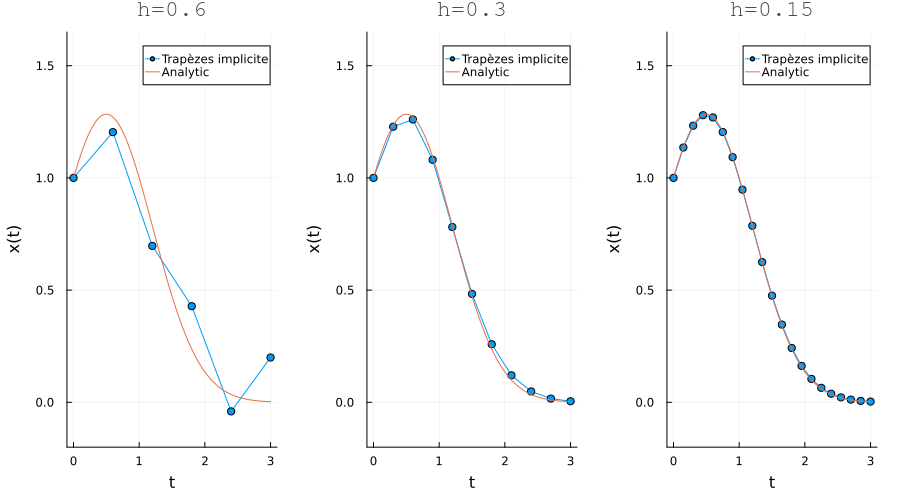

In [128]:
# Solution approchée et solution exacte
method = :trapezes_implicite
Nspan  = [5, 10, 20]

# Calcul des graphiques
plts = convergence(method, f, x0, tspan, sol, Nspan)

# Affichage des graphiques
plot(plts..., layout=(1, length(Nspan)), size=(900, 500))

Méthode d'intégration : Trapèzes implicite

constante du grand O : K = 0.39404
ordre de convergence : p = 2.08569


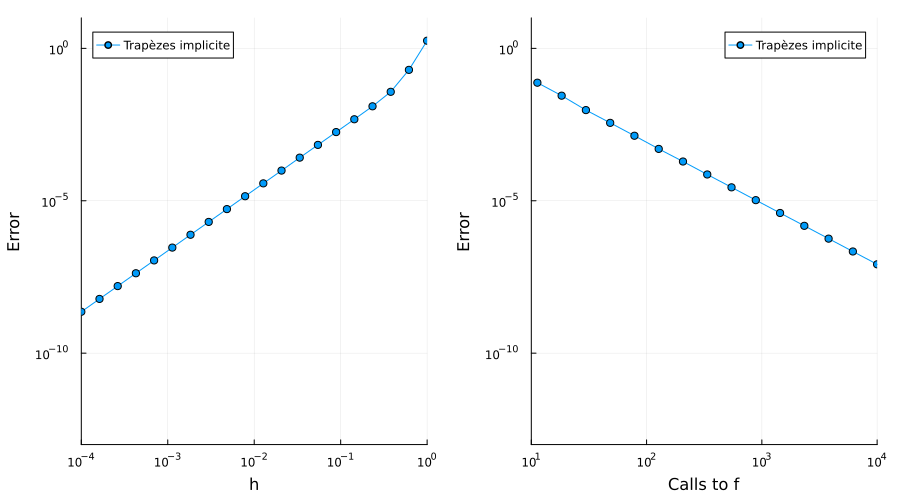

In [129]:
# Ordre de convergence de la méthode
method  = :trapezes_implicite
hspan   = hspan_[1e-7 .≤ hspan_ .≤ 1]
Nfespan = Nfespan_[10 .≤ Nfespan_ .≤ 1e7]

# Calcul du graphique
plt_order_euler = ordre(method, f, x0, tspan, sol, hspan, Nfespan)

# Affichage du graphique
plot(plt_order_euler..., layout=(1, 2), size=(900, 500))

## La méthode de Gauss à 2 étages

La méthode de Gauss à 2 étages est donnée par le tableau de Butcher :

$$
    \begin{array}{c | c c}
        1/2 - \sqrt{3}/6     & 1/4  & 1/4 - \sqrt{3}/6  \\[0.2em]
        1/2 + \sqrt{3}/6     & 1/4 + \sqrt{3}/6 & 1/4   \\[0.2em]
        \hline
        & 1/2 & 1/2 \\
    \end{array}
$$

### Exercice 3

1. Implémenter la méthode de Gauss à 2 étages avec le point fixe.
2. Tracer la solution approchée et la solution exacte sur le même graphique pour différentes valeurs de $h$ que vous choisirez pour illustrer la convergence de la méthode.
3. Tracer l'erreur globale de la méthode de Gauss à 2 étages. Quel est l'ordre de convergence de la méthode de Gauss à 2 étages ?

In [130]:
# Implémentation de la méthode de Gauss à 2 étages implicite
function gauss2_implicite(f, x0, tspan, N)
    k = [f(tspan[1], x0), f(tspan[1], x0)]
    A = [1/4 1/4-sqrt(3)/6; 1/4+sqrt(3)/6 1/4]
    C = [1/2-sqrt(3)/6; 1/2+sqrt(3)/6]
    B = [1/2; 1/2]
    return integration(f, tspan, x0, k, A, C, B, N)
end;

Méthode d'intégration : Gauss implicite


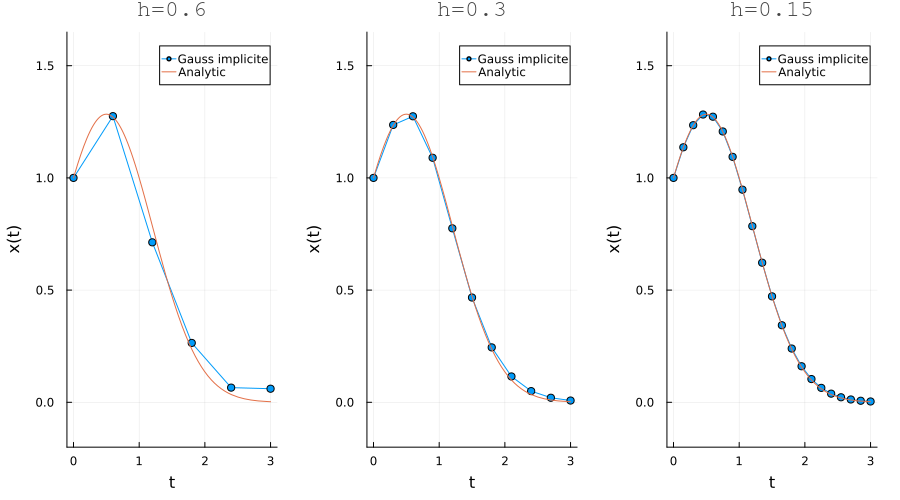

In [131]:
# Solution approchée et solution exacte
method = :gauss2_implicite
Nspan  = [5, 10, 20]

# Calcul des graphiques
plts = convergence(method, f, x0, tspan, sol, Nspan)

# Affichage des graphiques
plot(plts..., layout=(1, length(Nspan)), size=(900, 500))

Méthode d'intégration : Gauss implicite

constante du grand O : K = 0.24615
ordre de convergence : p = 2.04036


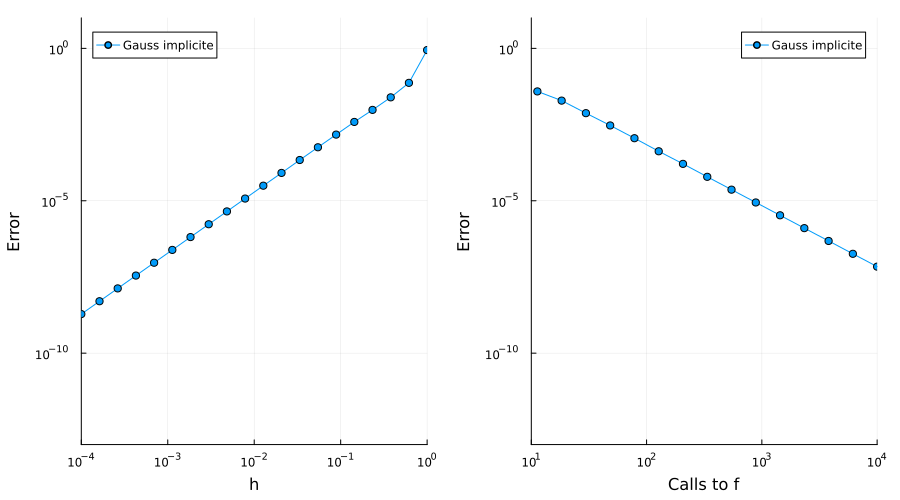

In [132]:
# Ordre de convergence de la méthode
method  = :gauss2_implicite
hspan   = hspan_[1e-7 .≤ hspan_ .≤ 1]
Nfespan = Nfespan_[10 .≤ Nfespan_ .≤ 1e7]

# Calcul du graphique
plt_order_euler = ordre(method, f, x0, tspan, sol, hspan, Nfespan)

# Affichage du graphique
plot(plt_order_euler..., layout=(1, 2), size=(900, 500))

## Un autre exemple

On considère à partir de maintenant l'équation différentielle en dimension 2 :

$$
    \dot{x}_1(t) = x_2(t), \quad \dot{x}_2(t) = - x_1(t).
$$

On peut montrer facilement que la norme de $x(t) = (x_1(t), x_2(t))$ est constante le long des solutions :

$$
    \frac{\mathrm{d}}{\mathrm{d} t} \|x(t)\|^2 = 2\, \left( x(t) \,|\, \dot{x}(t) \right) =  2 \left( x_1(t) x_2(t) - x_2(t) x_1(t) \right) = 0.
$$

### Exercice 4

On considère le problème de Cauchy associé de condition initiale $x_0 = (1, 0)$.

1. Afficher l'approximation de la solution sur $[0, 10]$ pour les méthodes :
- Euler explicite ;
- Euler implicite ;
- Trapèzes ;
- Gauss à 2 étages.
2. Commentaires.

**Attention :** vous ferez un affichage dans le plan $(x_1, x_2)$. Vous fixerez le nombre de pas à $N=100$.

In [133]:
# Affichage des résultats

